In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import PIL
import shutil
import zipfile
import glob
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

In [3]:
root_set_dir = "C:/Users/User/강동현/2024 RND"

In [22]:
train_image_source = "/TT image_50"
test_image_source = "/origin image"

train_image_set_dir = root_set_dir+train_image_source
test_image_set_dir = root_set_dir+test_image_source

In [23]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [24]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
])

In [25]:
train_len = 9000
valid_len = 800
test_len = 200

train_dog_dataset = CustomDataset(dog_files[:train_len], train_image_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:train_len], train_image_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[train_len:train_len+valid_len], train_image_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[train_len:train_len+valid_len], train_image_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[train_len+valid_len:train_len+valid_len+test_len], test_image_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[train_len+valid_len:train_len+valid_len+test_len], test_image_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [26]:
print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

number of train dataset : 18000
number of valid dataset : 1600
number of test dataset : 400


In [27]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

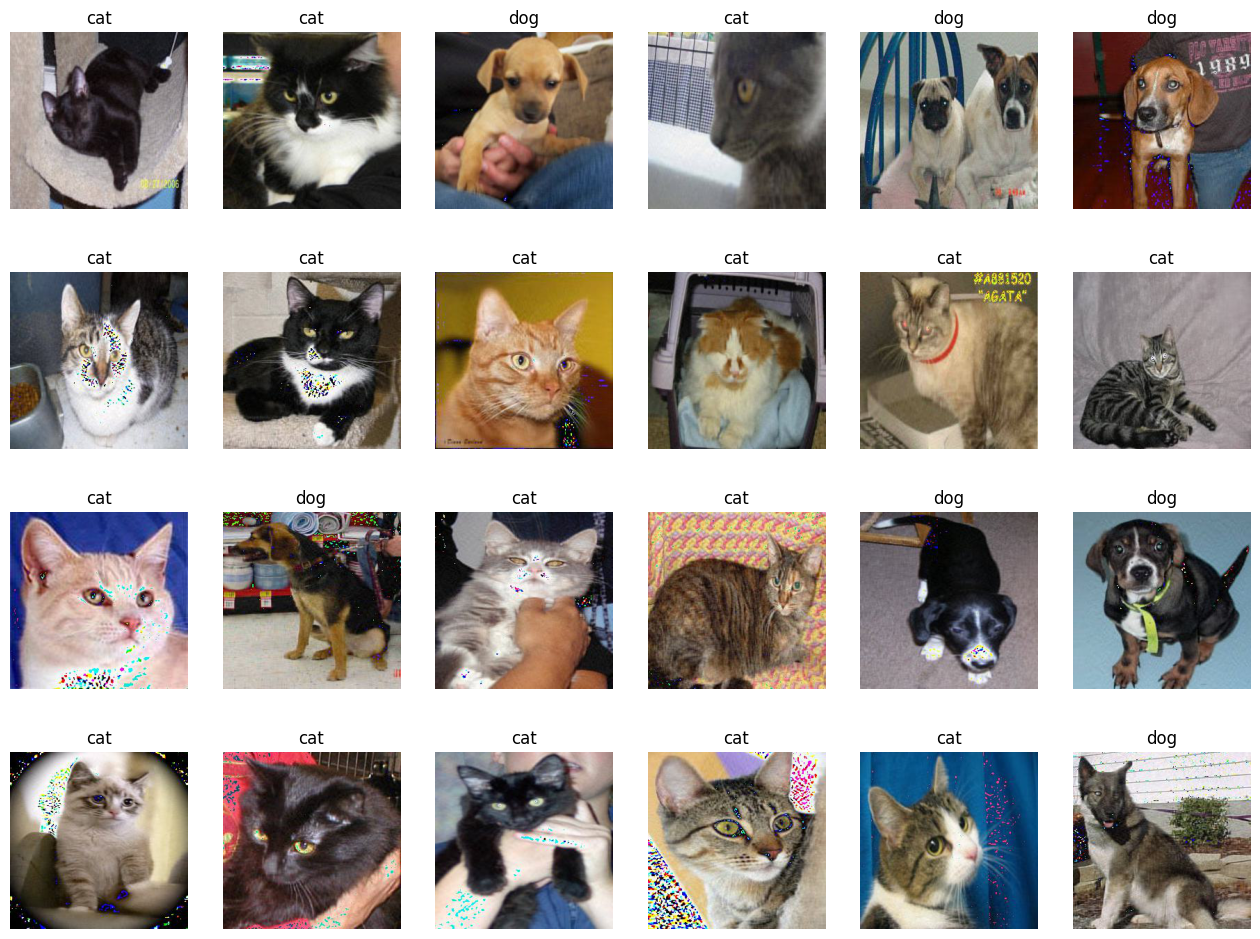

In [28]:
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

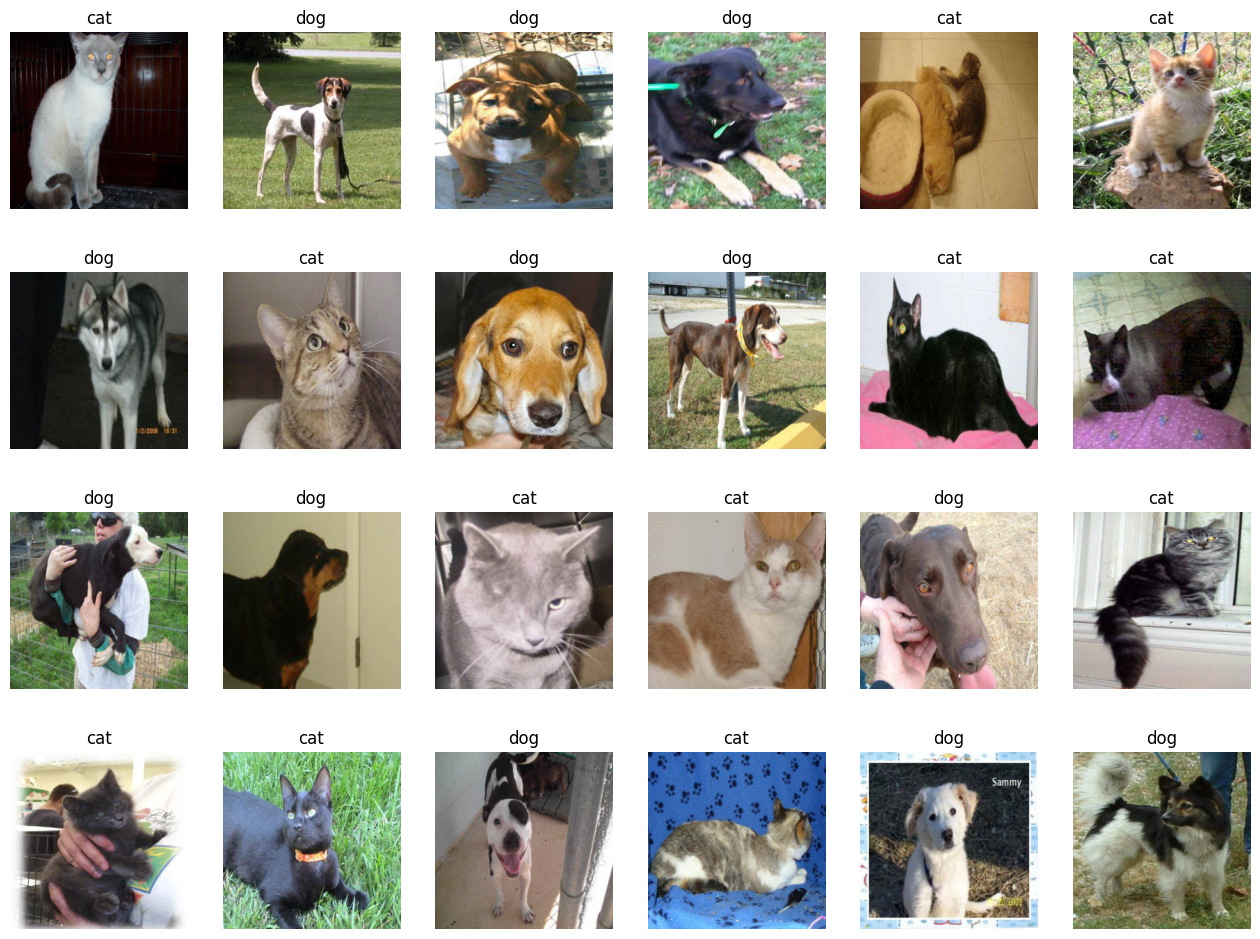

In [29]:
samples, labels = next(iter(test_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [30]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1) 

        self.dropout = nn.Dropout(0.5) # 0.25 해보고 0.5로 해보기. 값 저장하고나서

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 256 * 16 * 16) 
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
      
        x = F.sigmoid(self.fc2(x))
        return x

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [32]:
import torch.optim as optim

criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [33]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        if epoch%10==0:
            print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    
    plt.legend()
    plt.title('loss')
    plt.show()
    
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

74.868sec : [Epoch 1/51] -> train loss: 0.6922, train acc: 52.333% / valid loss: 0.6909, valid acc: 56.875%
65.685sec : [Epoch 11/51] -> train loss: 0.5476, train acc: 72.339% / valid loss: 0.5479, valid acc: 71.250%
63.673sec : [Epoch 21/51] -> train loss: 0.3800, train acc: 82.767% / valid loss: 0.4635, valid acc: 78.938%
63.392sec : [Epoch 31/51] -> train loss: 0.1533, train acc: 94.094% / valid loss: 0.4852, valid acc: 81.500%
63.031sec : [Epoch 41/51] -> train loss: 0.0502, train acc: 98.339% / valid loss: 0.6316, valid acc: 82.125%
63.406sec : [Epoch 51/51] -> train loss: 0.0275, train acc: 99.056% / valid loss: 0.7489, valid acc: 81.750%


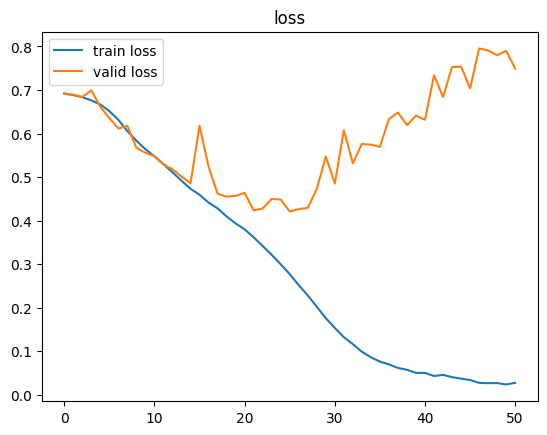

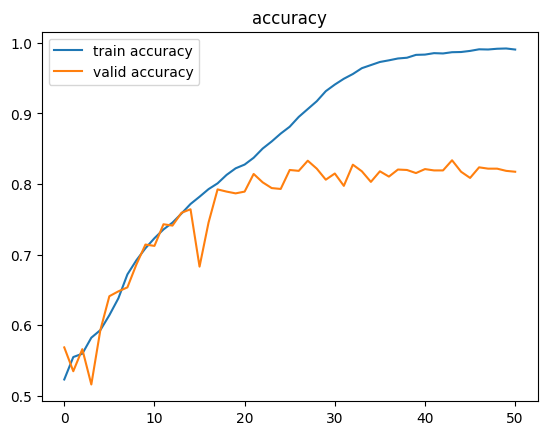

In [34]:
train_losses, train_accuracies, valid_losses, valid_accuracies = fit(model, criterion, optimizer, 50+1, train_loader, valid_loader)

In [38]:
torch.save(model, 'model 50.pt')
#loaded_model = torch.load('model_state_dict.pt')

In [39]:
np.save("train_losses_50.npy", train_losses)
np.save("train_accuracies_50.npy", train_accuracies)
np.save("valid_losses_50.npy", valid_losses)
np.save("valid_accuracies_50.npy", valid_accuracies)

In [35]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            #print(y_pred)
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            print(y_pred)
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')
    
    return losses/len(test_loader), correct/len(test_loader.dataset)*100

In [36]:
eval_loss, eval_acc = eval(model, criterion, test_loader)

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]])
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
    

In [37]:
eval_loss, eval_acc

(0.6425769260296454, tensor(86.))